In [13]:
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from utils import *

In [14]:
os.environ["PYTHONHASHSEED"] = "0"
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [15]:
folder_path = './points'

x, y = read_data(folder_path, people=["pedro"])

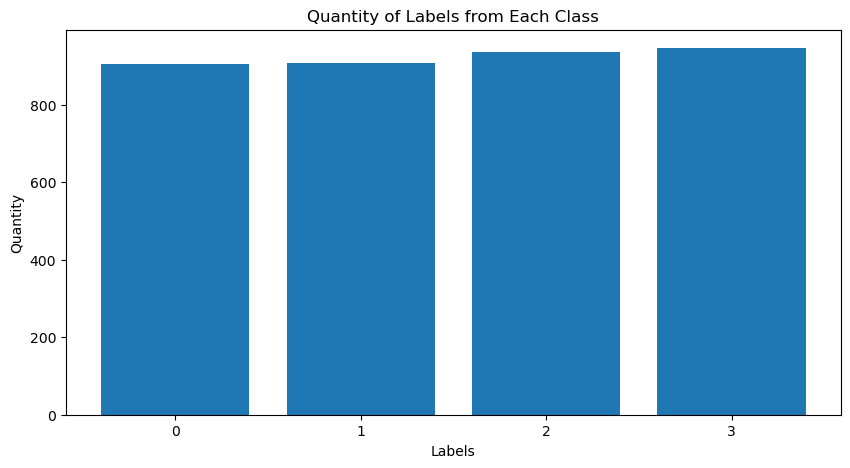

[0 1 2 3]
4


In [16]:
draw_bar_chart(y)

print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

In [17]:
# shuffle
x, y = shuffle(x, y, random_state=0)

# split
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=1/5, random_state=0, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=1/4, random_state=0, stratify=y_temp, shuffle=True)

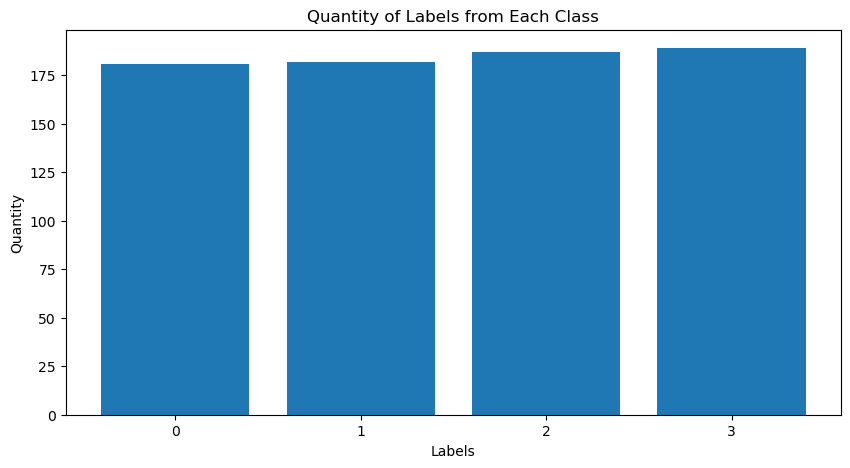

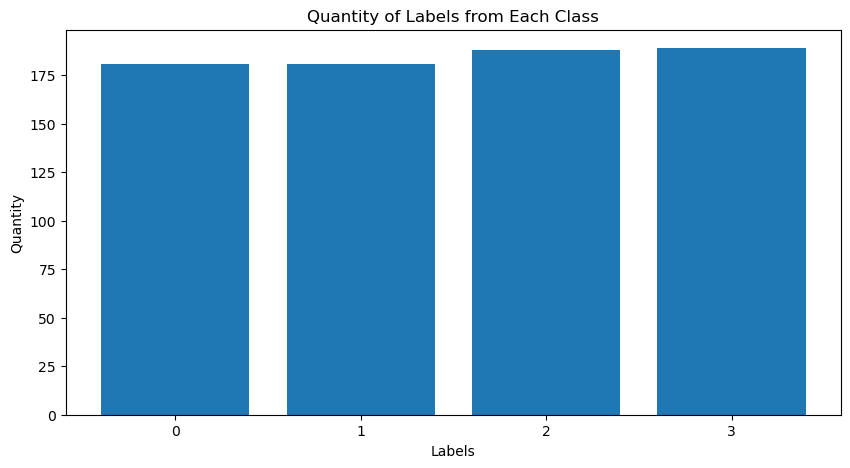

In [18]:
draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [19]:
def create_model(input_shape, dropout=0.5, learning_rate=0.001, kernel_size=3, num_conv_layers=2):
   # Create a `Sequential` model and add a Dense layer as the first layer.
   model = tf.keras.models.Sequential()
   model.add(tf.keras.Input(shape=input_shape))
   for _ in range(num_conv_layers):
      model.add(tf.keras.layers.Conv1D(64, kernel_size, activation='relu'))
   #model.add(tf.keras.layers.MaxPooling1D(2,1))
   model.add(tf.keras.layers.Flatten())
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(128, activation='relu'))
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(32, activation='relu'))
   model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))

   model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=["sparse_categorical_accuracy"]
   )
   return model

In [20]:
all_results = []

for _ in range(5):
    input_shape = x.shape[1:]

    model = create_model(input_shape)

    model.summary()

    callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

    results = model.fit(
        x_train,
        y_train,
        validation_data=(x_val,y_val),
        epochs=10000,
        batch_size=128,
        callbacks=callbacks,
    )

    model.evaluate(x_val, y_val, verbose=1)

    l, a = model.evaluate(x_test, y_test, verbose=1)

    all_results.append([l, a])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 19, 64)            640       
                                                                 
 conv1d_11 (Conv1D)          (None, 17, 64)            12352     
                                                                 
 flatten_5 (Flatten)         (None, 1088)              0         
                                                                 
 dropout_10 (Dropout)        (None, 1088)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               139392    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 32)               

In [21]:
print(all_results)

[[0.32775968313217163, 0.9147496819496155], [0.2758471369743347, 0.9377537369728088], [0.31419190764427185, 0.9161028265953064], [0.2982747256755829, 0.9269282817840576], [0.27334317564964294, 0.9255750775337219]]


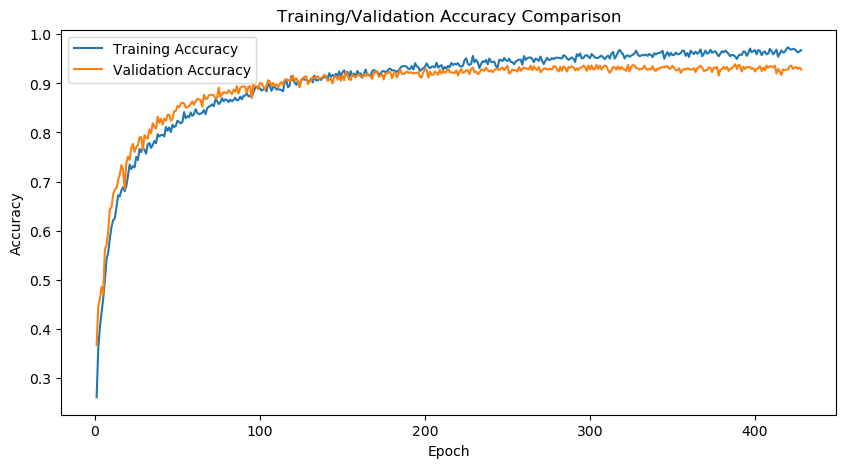

In [22]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"])

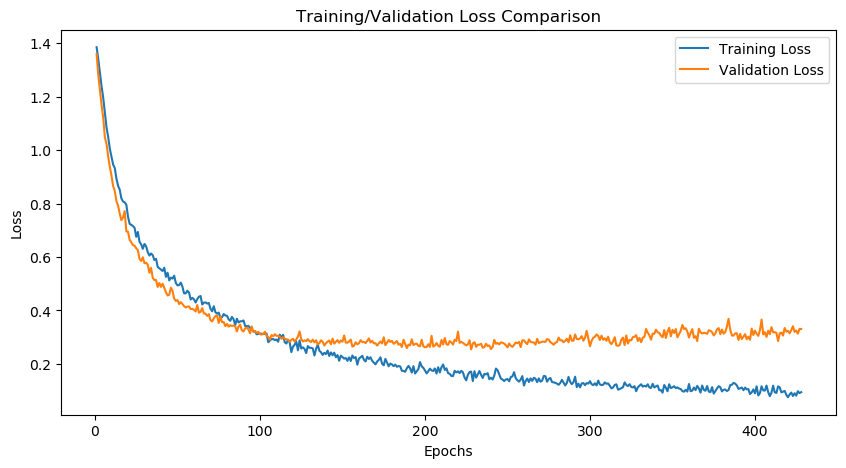

In [23]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

24/24 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       171
           1       0.94      0.93      0.94       183
           2       0.94      0.89      0.91       198
           3       0.95      0.96      0.95       187

    accuracy                           0.93       739
   macro avg       0.93      0.93      0.93       739
weighted avg       0.93      0.93      0.93       739



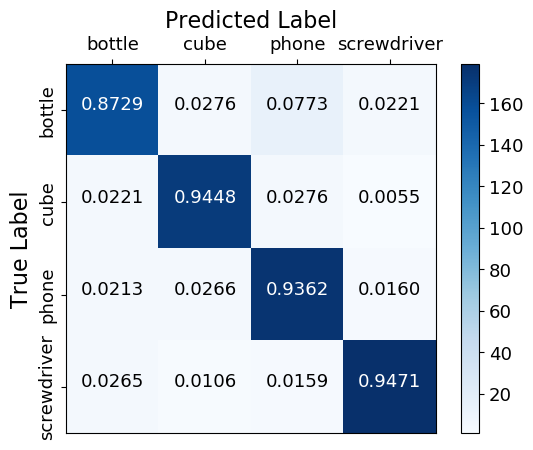

In [24]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_pred,y_test))
plot_confusion_matrix(y_test, y_pred, ["bottle", "cube", "phone", "screwdriver"])